# Phishing URL Detection: Random Forest Classification

<br>

## 1. Introduction

The purpose of this model is to classify wether or not a URL is legitimate, or a phishing attempt. Phishing is a type of social engineering attack often used to steal user data, including login credentials and credit card numbers. In this case, phishing is determined from the URL - including special characters, redirects, ssl, and domain information.

The model employs RandomForest Classification to make these predictions. Random Forest Classification is a machine learning algorithm that uses an ensemble of decision trees to make predictions, particularly for classification tasks. It combines the predictions of multiple, uncorrelated decision trees to improve accuracy and robustness. 

To test the final model, execute `streamlit run app.py`. You can also run it via the deployed model [here](https://phishingurlmodel-gpheh7xkq9urwtjkz6eyzm.streamlit.app).

<br>

## 2. Data Overview

### Data Acquisition

The original data aqcuired from Kaggle can be accessed through the link provided below:
- [Download Data](https://www.kaggle.com/datasets/danielfernandon/web-page-phishing-dataset)

### Key Features of the Dataset

- **url_length**:  The length of the URL.

- **n_slash**: The count of ‘/’ characters in the URL.

- **n_questionmark**: The count of ‘?’ characters in the URL.

- **n_equal**: The count of ‘=’ characters in the URL.

- **n_at**: The count of ‘@’ characters in the URL.

- **n_and**:  The count of ‘&’ characters in the URL.

- **n_exclamation**: The count of ‘!’ characters in the URL.

- **n_asterisk**: The count of ‘*’ characters in the URL.

- **n_hastag**: The count of ‘#’ characters in the URL.

- **n_percent**: The count of ‘%’ characters in the URL.

- **dots_per_length**: The amount of '.' per URL query.

- **hyphens_per_length**: The amount of '-' per URL query.

- **is_long_url**: Is the URL query an abnormally long string.

- **has_many_dots**: Does it have abnomormal amounts of '.'

- **has_ssl**: Does it have an SSL certificate.

- **is_cloudflare_protected**: Is the URL Cloudflare protected.

- **special_char_density**: Ratio of special characters (*&@#) within URL.

- **suspicious_tld_risk**: Risk of URL containing suspicious extensions, domains, and patterns.

- **has_redirects**: Does URL have redirects.

- **risk_score**: Ultimate risk score of URL based on characteristics.

- **url_complexity**: Ultimate URL complexity based on characteristics.

- **phishing**: The Labels of the URL. 1 is phishing and 0 is legitimate.

<br>

## 3. Initial Data Exploration

In this section, the necessary libraries and datasets needed for analysis will be imported and initialized.

The following libraries are used:

- Library `pandas` will be required to work with data in tabular representation.

- Library `numpy` will be required to round the numerical data.

- Library `matplotlib`, `seaborn` will be required for data visualization.

- Library `sklearn` will be used to train the model.

- Library `joblit` will be used to export the model for deployment.

In [173]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings

# Settings
sns.set_theme(style="darkgrid")
pd.set_option('display.max_rows', 10)

# Set up logging
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.random.seed(0)

In [174]:
# Read and import data
data_df = pd.read_csv('../data/web-page-phishing.csv')

# Dimensions of data
print("Number of rows within data: ", data_df.shape[0])
print("Number of columns within data: ", data_df.shape[1])

# Display data
data_df.head()

Number of rows within data:  100077
Number of columns within data:  20


,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
0,37,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,77,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,126,4,1,2,0,1,3,0,2,0,0,0,0,0,0,0,0,0,1,1
3,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,55,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


<br>

## 4. Data Cleaning and Preprocessing

In this section, data pre-processing will be conducted by examining data types, addressing missing values, removing duplicates, analyzing measures of central tendency, and extracting features.

### 4.1 Feature Extraction

New features can be beneficial for future training, such as the presence of SSL certificates, domain age, and Cloudflare protection. These values are not currently in the data, so for training purposes, it will be randomized.

In [175]:
# Create copy and shuffle
data_copy = data_df.copy()
data_copy.sample(frac=1).reset_index(drop=True)
data_copy.head()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
0,37,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,77,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,126,4,1,2,0,1,3,0,2,0,0,0,0,0,0,0,0,0,1,1
3,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,55,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


The number of characters, such as dots and hyphens, can be replaced by a ratio - as in how many are there per url length. The more dots and hyphens, the more the probability that it could be a phishing link. These values will be extracted in the deployed app.

In [176]:
# Feature replacement
data_copy['dots_per_length'] = data_copy['n_dots'] / (data_copy['url_length'] + 1)
data_copy['hyphens_per_length'] = data_copy['n_hypens'] / (data_copy['url_length'] + 1)
data_copy['is_long_url'] = (data_copy['url_length'] > 75).astype(int)
data_copy['has_many_dots'] = (data_copy['n_dots'] > 4).astype(int)
data_copy['has_redirects'] = (data_copy['n_redirection'] > 0).astype(int)

SSL certificates and Cloudflare protection give URLs more credibility, as links not using these factors are more likely to be insecure links. Thus these features should be added to the data. SSL certificates will be given to 70% of non-phishing data, and 30% of phishing data. Cloudflare status will be given to 40% of non-phishing data, and 5% of phishing data. These values will be extracted in the deployed app.

In [177]:
# Add has_ssl column (1 for all legitimate URLs, random for phishing)
data_copy['has_ssl'] = 1
phishing_mask = data_copy['phishing'] == 1
data_copy.loc[phishing_mask, 'has_ssl'] = np.random.choice(
    [0, 1], 
    size=sum(phishing_mask), 
    p=[0.7, 0.3]
)

# Add cloudflare protection (randomized with specific distribution)
data_copy['is_cloudflare_protected'] = 0
legitimate_mask = data_copy['phishing'] == 0
data_copy.loc[legitimate_mask, 'is_cloudflare_protected'] = np.random.choice(
    [0, 1], 
    size=sum(legitimate_mask), 
    p=[0.6, 0.4]
)
data_copy.loc[phishing_mask, 'is_cloudflare_protected'] = np.random.choice(
    [0, 1], 
    size=sum(phishing_mask), 
    p=[0.95, 0.05]
)

Special character density (jyc$z$wfy7c3ueg*&vsdfyiu), and certain subdomains, domains, and public suffixes are repeatedly used in phishing sites. Thus should be kept in account during our training. These values will be extracted in the deployed app.

In [178]:

# Special character density (higher in phishing URLs)
data_copy['special_char_density'] = (
    data_copy['n_hypens'] + data_copy['n_underline'] + 
    data_copy['n_at'] + data_copy['n_equal'] + data_copy['n_dollar'] + 
    data_copy['n_percent'] + data_copy['n_hastag']
) / (data_copy['url_length'] + 1)

# Suspicious TLD approximation (can't directly check TLD without URL string)
data_copy['suspicious_tld_risk'] = 0
 # 70% medium/high risk for phishing
data_copy.loc[phishing_mask, 'suspicious_tld_risk'] = np.random.choice(
    [0, 1, 2], 
    size=sum(phishing_mask), 
    p=[0.3, 0.4, 0.3] 
)
 # 80% low risk for legitimate
data_copy.loc[legitimate_mask, 'suspicious_tld_risk'] = np.random.choice(
    [0, 1, 2], 
    size=sum(legitimate_mask), 
    p=[0.8, 0.15, 0.05] 
)

Finally, the amount of redirections, risk score, and url_complexity as a whole will need to be added to the data. The more complex the URL, the more likely it is to be a phishing attempt, which means it has a higher risk score.

In [179]:
# Combined risk score based on multiple factors
data_copy['risk_score'] = (
    data_copy['is_long_url'] * 2 +
    data_copy['has_many_dots'] * 1.5 +
    data_copy['special_char_density'] * 10 +
    data_copy['has_redirects'] * 3 -
    data_copy['has_ssl'] * 2 -
    data_copy['is_cloudflare_protected'] * 2
)

# Suspicious URL complexity (higher in phishing URLs)
data_copy['url_complexity'] = (
    data_copy['url_length'] * 0.01 +
    data_copy['n_dots'] * 0.5 +
    data_copy['n_hypens'] * 0.3 +
    data_copy['n_questionmark'] * 0.7 +
    data_copy['n_equal'] * 0.7 +
    data_copy['n_at'] * 2
)

Now, all that remains is to drop the unnecessary columns and rearrange the DataFrame. The data will also be saved, as the data from the Streamlit app will be appended to this file. This file can then be used later in a pipeline to continuously train the model on new results.

In [180]:
# Format
data_copy.drop(['n_dots', 'n_hypens', 'n_redirection', 'n_underline', 'n_space', 'n_tilde', 'n_comma', 'n_plus', 'n_dollar'], axis=1, inplace=True)
data_copy = data_copy[['url_length', 'n_slash', 'n_questionmark', 'n_equal', 'n_at', 'n_and',
       'n_exclamation', 'n_asterisk', 'n_hastag', 'n_percent', 
       'dots_per_length', 'hyphens_per_length', 'is_long_url', 'has_many_dots',
       'has_ssl', 'is_cloudflare_protected', 'special_char_density', 'suspicious_tld_risk', 'has_redirects',
       'risk_score', 'url_complexity','phishing']]
data_copy.head()

# Save data
data_copy.to_csv('../data/final_data.csv', index=False)

**CONCLUSION:** 

All necessary features have been extracted. Therefore, no further data transformation is necessary.

### 4.2 Missing Data

In [181]:
# Missing data
data_copy.isnull().sum()

url_length             0
n_slash                0
n_questionmark         0
n_equal                0
n_at                   0
                      ..
suspicious_tld_risk    0
has_redirects          0
risk_score             0
url_complexity         0
phishing               0
Length: 22, dtype: int64

**CONCLUSION:**

The dataset contains no missing values, so no additional modifications are needed.

### 4.3 Duplicate Data

In [182]:
# Duplicate data
data_copy.duplicated().any()

True

In [183]:
# Frequency count
cols = data_copy.columns
for col in cols:
    print(f"\n{data_copy[col].unique()}")
    print(f"{data_copy[col].value_counts()}")


[  37   77  126   18   55   32   19   81   42  104   56   43   83   31
   25   51   50   34   27   63   66   40   48   41   36   72   68  163
   26   64   61   35  113   23   84   29   98   15   65  131   45  159
   44  103   46   38  112   39   99   60   74   52   88   54   67   62
   59   57   92  102  119  151   28   16   22   30   76  430   73   70
   90   71  114  127   33  122   53  101   49  108   80  342   24   94
  204   75  210  150  106  129  118   78   86  137  263   89  128   85
  109  110  171   17  132  124  141   21   79   97  231   58   87  133
   47   93  154  271  282  144  238  123   82  259  105  152  115  552
  393  409  121   20  216  241  392  192  172  187   91  260  229   95
   96  439  116  120  111   69  155  136  167  262  183  246  266  117
  197  243  157  339  125  100  130  459  186  138  162  565  396  189
  107  143  145  213  275  249 1386  199  148  181  276   13  458  201
  134  227  256  234  360  236  237  315  217  147  139  169  160  165
  149

**CONCLUSION:** 

Only valid duplicates exist. Therefore, no further data transformation is necessary.

### 4.4 Transformation

In [184]:
# Data types
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100077 entries, 0 to 100076
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   url_length               100077 non-null  int64  
 1   n_slash                  100077 non-null  int64  
 2   n_questionmark           100077 non-null  int64  
 3   n_equal                  100077 non-null  int64  
 4   n_at                     100077 non-null  int64  
 5   n_and                    100077 non-null  int64  
 6   n_exclamation            100077 non-null  int64  
 7   n_asterisk               100077 non-null  int64  
 8   n_hastag                 100077 non-null  int64  
 9   n_percent                100077 non-null  int64  
 10  dots_per_length          100077 non-null  float64
 11  hyphens_per_length       100077 non-null  float64
 12  is_long_url              100077 non-null  int32  
 13  has_many_dots            100077 non-null  int32  
 14  has_

**CONCLUSION:** 

All data are in the correct types and formats; therefore, no further data transformation is needed.

### 4.5 Outliers

Outliers can distort and mislead the analysis process, resulting in inaccurate predictions and insights. Therefore, addressing outliers is essential when preparing data for analysis or machine learning models. 

Generating summary statistics is a quick and effective way to assess whether a dataset contains outliers.

In [185]:
# Summary statistics
data_copy.describe().round(2)

,url_length,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_asterisk,n_hastag,n_percent,...,is_long_url,has_many_dots,has_ssl,is_cloudflare_protected,special_char_density,suspicious_tld_risk,has_redirects,risk_score,url_complexity,phishing
count,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,...,100077.0,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00,100077.00
mean,39.18,1.14,0.02,0.22,0.02,0.14,0.00,0.00,0.00,0.11,...,0.1,0.03,0.75,0.28,0.01,0.52,0.34,-0.65,1.84,0.36
std,47.97,1.83,0.17,0.96,0.27,0.91,0.08,0.28,0.06,1.70,...,0.3,0.17,0.43,0.45,0.02,0.73,0.48,2.22,1.85,0.48
min,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-4.00,0.54,0.00
25%,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,1.16,0.00
50%,24.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,1.00,0.00,0.00,0.00,0.00,-1.00,1.26,0.00
75%,44.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,1.00,1.00,0.02,1.00,1.00,1.00,1.83,1.00
max,4165.00,44.00,9.00,23.00,43.00,26.00,10.00,60.00,13.00,174.00,...,1.0,1.00,1.00,1.00,0.36,2.00,1.00,8.05,91.68,1.00


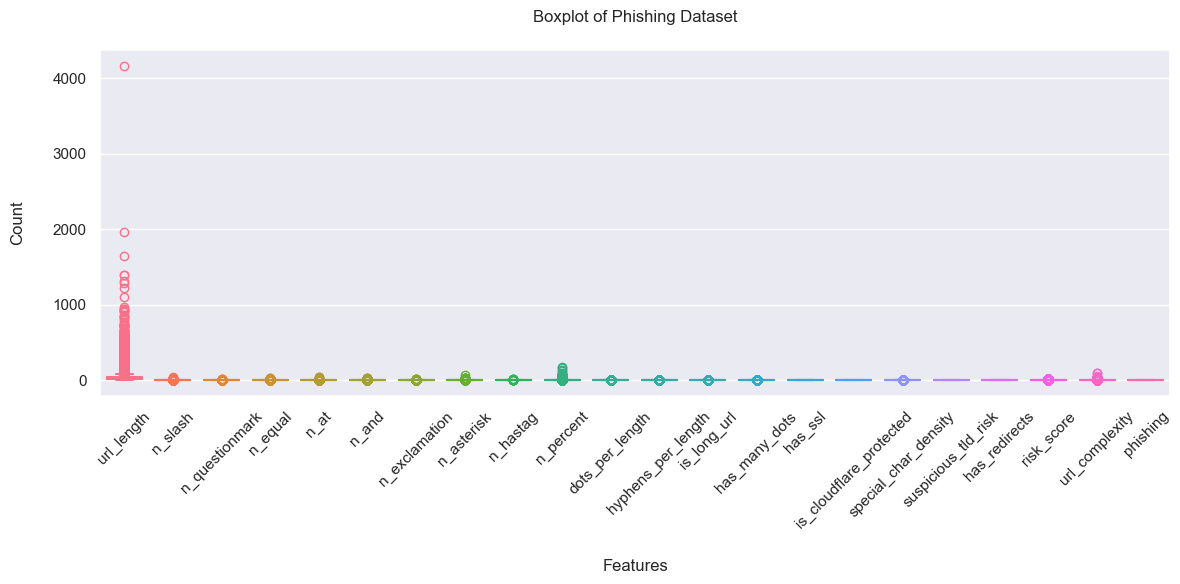

In [186]:
# Countplot
plt.figure(figsize=(12, 6))
sns.boxplot(data_copy, fill=False, gap=.1)
plt.title('Boxplot of Phishing Dataset', pad=20)
plt.ylabel('Count', labelpad=20)
plt.xlabel('Features', labelpad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**CONCLUSION:**

Upon examining the distributions above, it is evident that there are a few distinct outliers. The outliers seem extreme - such as `url_length` having a mean of 39.18 and a max of 4165.00, but this is merely due to an issue with class imbalance. 

Scaling will be applied post-train-test-split to mitigate outlier effects and prevent data leakage, ensuring representative training for both phishing and legitimate URL patterns.

<br>

## 5. Exploratory Data Analysis

In this section, we explore the dataset to understand the relationships, correlations, and distribution of key features.

Number of non-phishing values:  63715
Number of phishing values:  36362


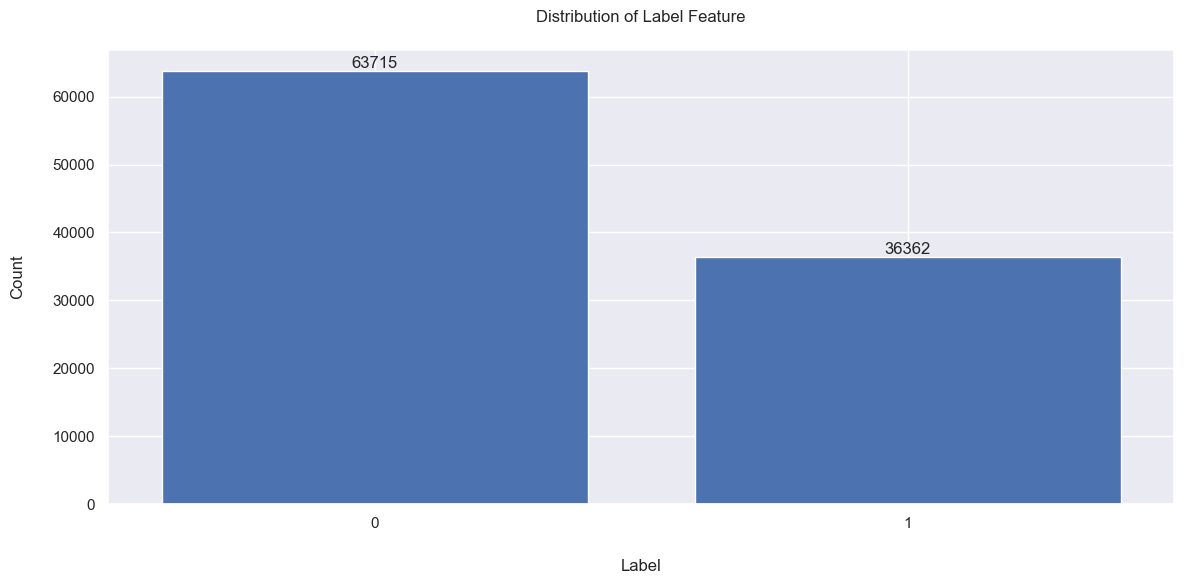

In [187]:
# Data distribution
print("Number of non-phishing values: ", len(data_copy[data_copy['phishing'] == 0]))
print("Number of phishing values: ", len(data_copy[data_copy['phishing'] == 1]))

# Distribution of Feature
counts = data_copy['phishing'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
bplot = plt.bar(counts.index, counts.values, align='center') 
plt.title('Distribution of Label Feature', pad=20)
plt.ylabel('Count', labelpad=20)
plt.xlabel('Label', labelpad=20)
plt.xticks([0, 1], ['0', '1'])
plt.xlim(-0.5, 1.5)
plt.bar_label(bplot)
plt.tight_layout()
plt.show()

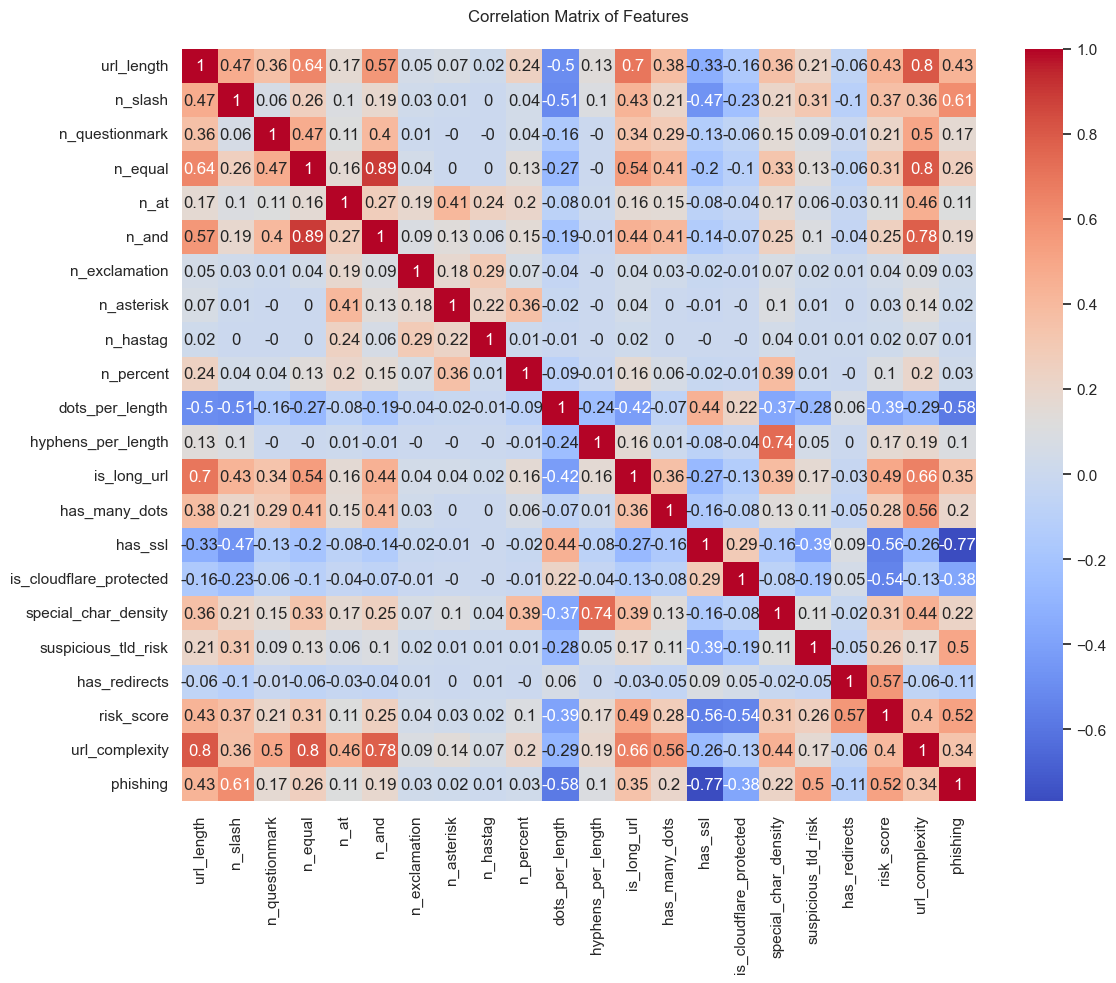

In [188]:
# Correlation Matrix
corr = data_copy.corr().round(2)
ndf = corr.loc[corr.max(axis=1) > 0.90, corr.max(axis=0) > 0.90]
plt.figure(figsize=(12, 10))
sns.heatmap(ndf, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix of Features", pad=20)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

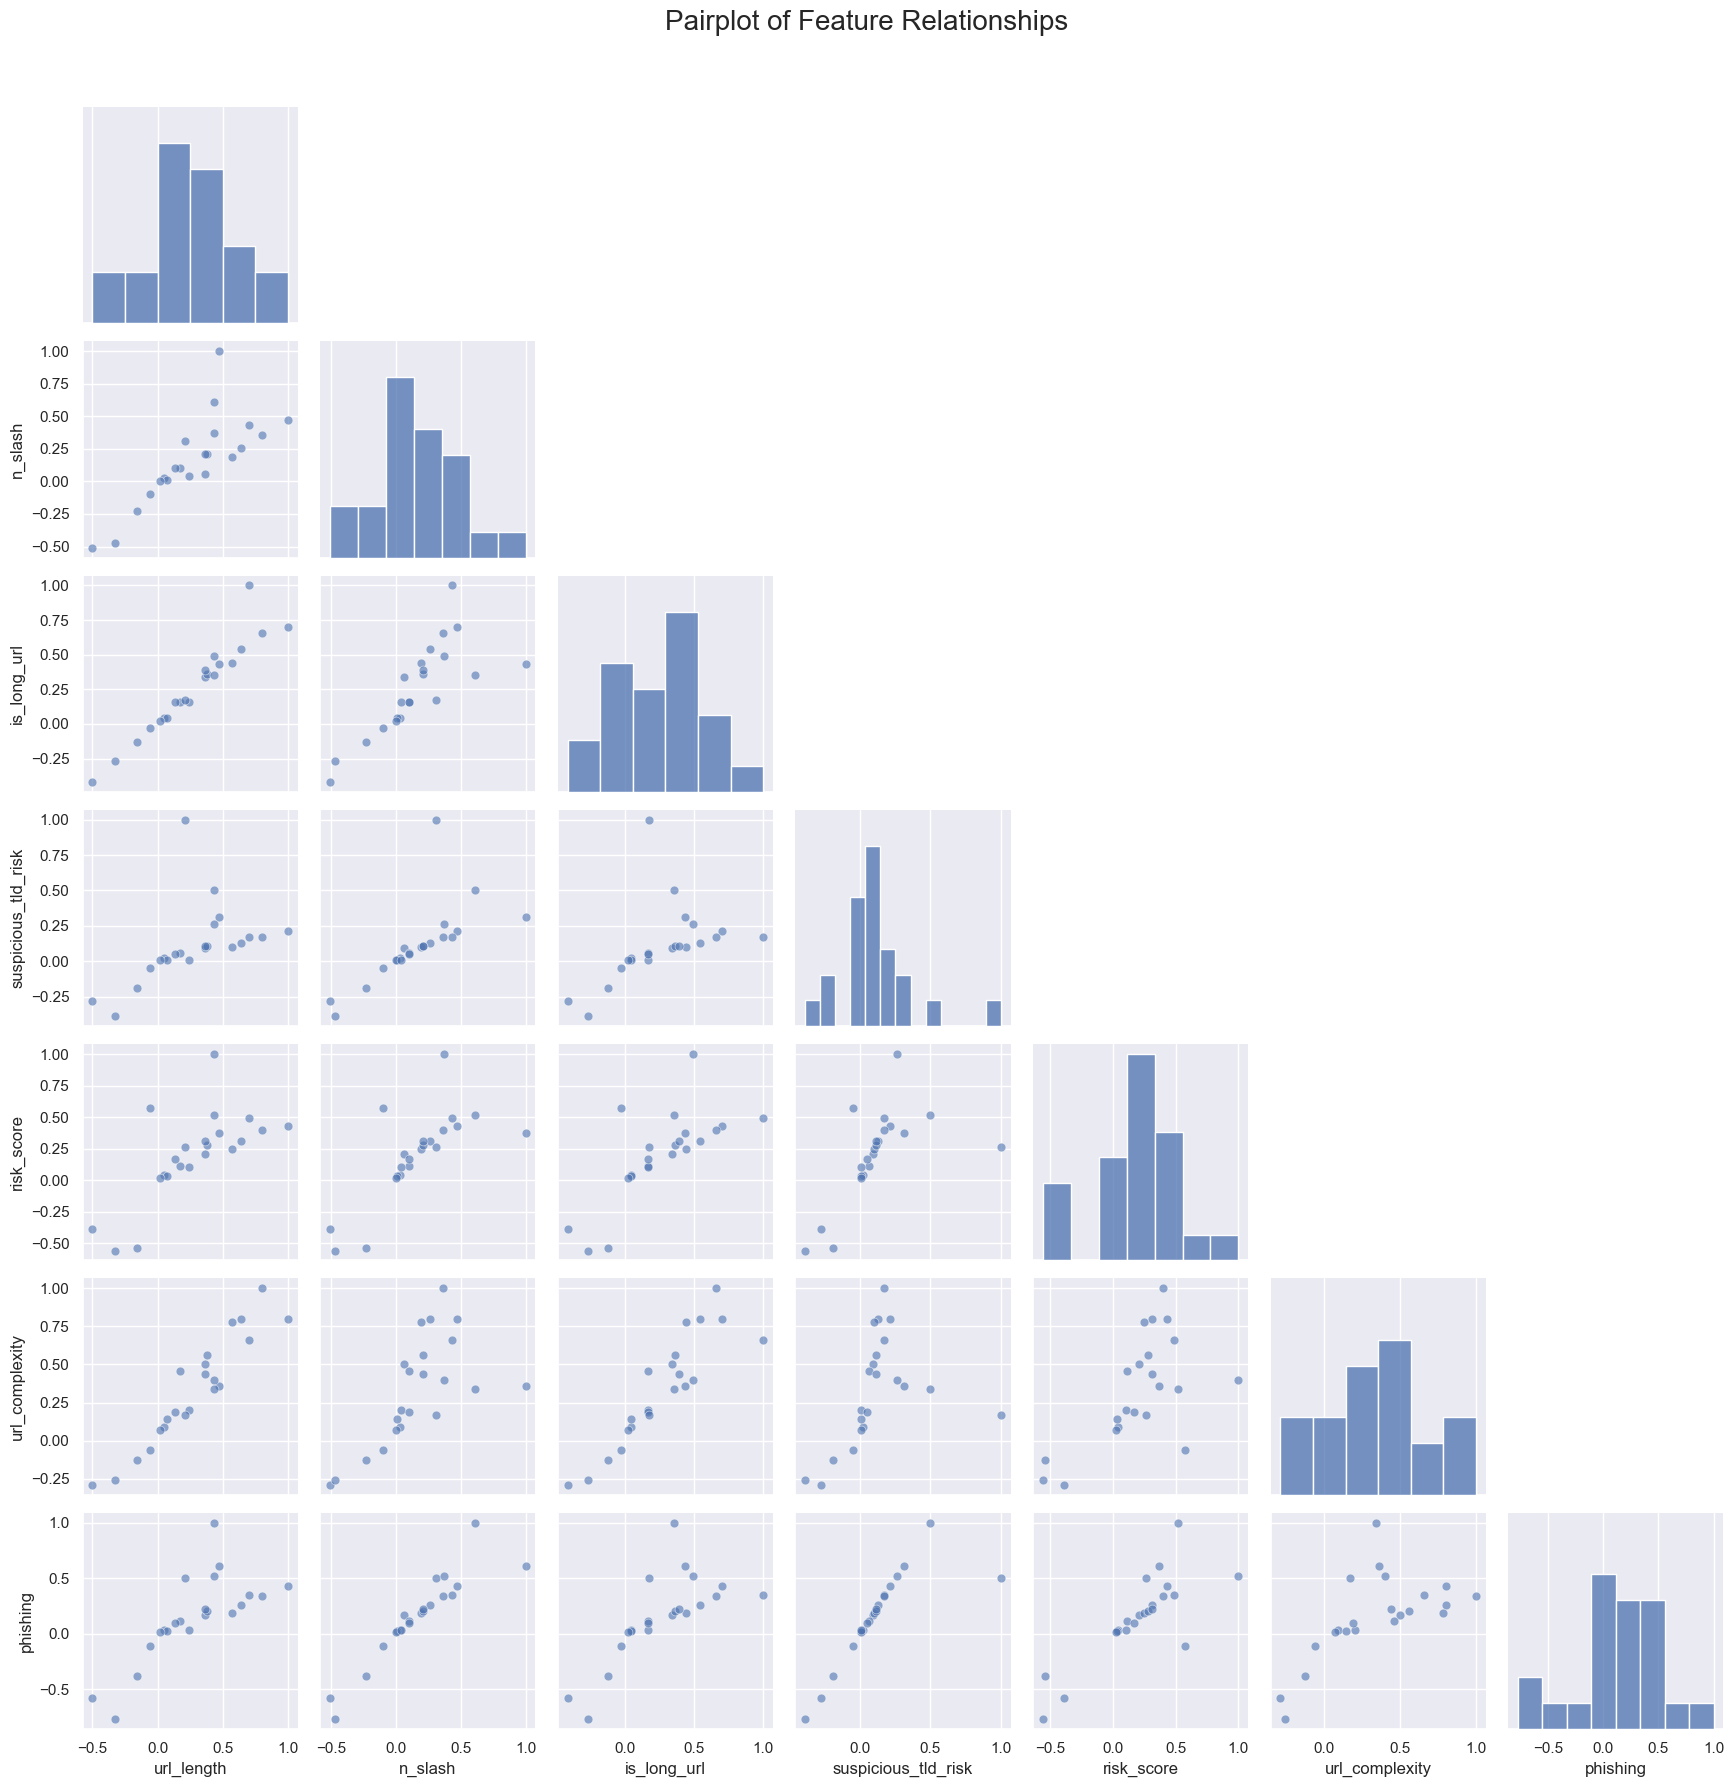

In [189]:
# Pairplot of relationships
plt.figure(figsize=(12,6))
sns.pairplot(
    corr[['url_length', 'n_slash', 'is_long_url', 'suspicious_tld_risk', 'risk_score', 'url_complexity', 'phishing']], 
    corner=True,              
    plot_kws={'alpha': 0.6, 's': 40},  
    diag_kws={'fill': True}
)
plt.suptitle("Pairplot of Feature Relationships", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [190]:
# Focus on High Correlations
corr_matrix = data_copy.corr()
phishing_corr = corr_matrix['phishing'].sort_values(ascending=False)
print("Correlation of Features to Phishing:")
print(phishing_corr.head(10))

Correlation of Features to Phishing:
phishing                1.000000
n_slash                 0.611472
risk_score              0.523655
suspicious_tld_risk     0.496871
url_length              0.430125
is_long_url             0.349660
url_complexity          0.340643
n_equal                 0.260462
special_char_density    0.215315
has_many_dots           0.203592
Name: phishing, dtype: float64


**CONCLUSION:**

The moderately strong linear correlations observed in `n_slash` (0.61) and `suspicious_tld_risk` (0.49) with phishing labels align with known attacker patterns - phishers often craft lengthy URLs with multiple slashes to mimic legitimate site structures while embedding malicious parameters. However, tree-based models like RandomForestClassifier excel at detecting complex non-linear relationships and feature interactions that simple correlation metrics might miss.

Retaining all features during testing and training allows the model to discover these multidimensional decision boundaries through recursive partitioning, where even weakly correlated features can contribute meaningfully in specific contexts.

<br>

## 6. Model Training & Evaluation

In this section, we will train the model using the provided data, enabling it to make precise and informed predictions based on the patterns and insights derived from the dataset. 

### 6.1 Feature Extraction

In [191]:
# Set features
X = data_copy.drop('phishing', axis=1)
y = data_copy['phishing']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

### 6.2 Data Preprocessing

In [192]:
# Scale data
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)  
X_scaled_test = scaler.transform(X_test)      
joblib.dump(scaler, '../scaler.pkl')

['../scaler.pkl']

### 6.3 Model Training

In [193]:
# Params
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 0.5],
    'n_estimators': [100, 200],
}

# Calculate class weights
phishing_weight = len(y_train) / (2 * np.bincount(y_train)[1])
not_phishing_weight = len(y_train) / (2 * np.bincount(y_train)[0])

# Train model
model = RandomForestClassifier(
    class_weight={0: not_phishing_weight, 1: phishing_weight},
    max_depth=10,
    random_state=42
)
grid_search = GridSearchCV(model, param_grid, scoring='precision', cv=3, n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)
best_model = grid_search.best_estimator_

### 6.4 Model Evaluation

In [194]:
# Predict the labels for the test set
y_pred = best_model.predict(X_scaled_test)

# Calculate f1, accuracy, precision, and recall
f1 = f1_score(y_test, y_pred, average='micro').round(2)
print(classification_report(y_test, y_pred, target_names=['Phishing', 'Not Phishing']))
print("F1 Score: ", f1)

              precision    recall  f1-score   support

    Phishing       0.96      0.97      0.97     50938
Not Phishing       0.95      0.94      0.94     29124

    accuracy                           0.96     80062
   macro avg       0.95      0.95      0.95     80062
weighted avg       0.96      0.96      0.96     80062

F1 Score:  0.96


In [195]:
# Cross Validation
cv_scores = cross_val_score(best_model, X_scaled_test, y_test, cv=5, scoring='f1_weighted')
print(f'Average cross-validated F1 score: {cv_scores.mean():.2f}')

Average cross-validated F1 score: 0.96


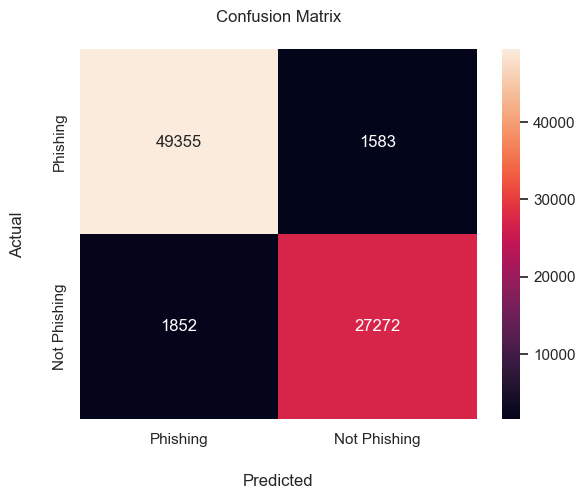

In [196]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Phishing', 'Not Phishing'], yticklabels=['Phishing', 'Not Phishing'])
plt.ylabel('Actual', labelpad=20)
plt.xlabel('Predicted', labelpad=20)
plt.title('Confusion Matrix', pad=20)
plt.show()

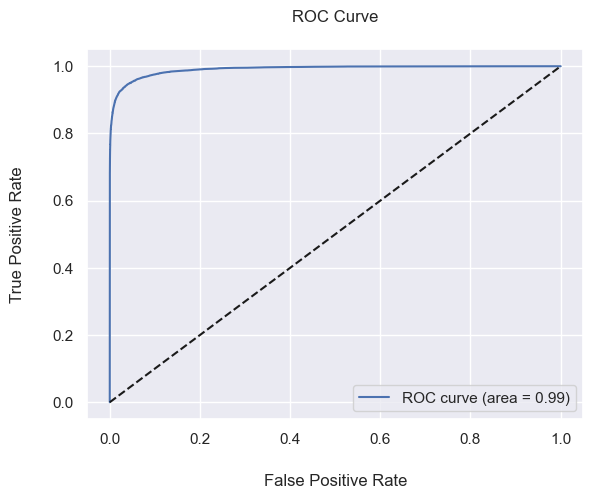

In [ ]:
# ROC curve
y_scores = best_model.predict_proba(X_scaled_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', labelpad=20)
plt.ylabel('True Positive Rate', labelpad=20)
plt.title('ROC Curve', pad=20)
plt.legend(loc='lower right')
plt.show()

**CONCLUSION:**

**Precision:**

- Of all urls predicted as phishing, 96% were correct. Of all predicted as not phishing, 95% were correct.

- Low false negatives — most phishing attempts are detected.

**Recall:**
- Of all true phishing urls, 97% were found. 

- Of all true not-phishing urls, 94% were found.

- Most legitimate urls are correctly identified, and only a small fraction are incorrectly flagged as phishing.

**F1-Score:**

- Harmonic balance between catching phishing and avoiding false alarms.

- This high score across folds suggests the model isn't overfitting to any particular data subset.

**ROC Curve**:

- A near-perfect area under the curve (AUC) of 0.99.

- This shape indicates that the model achieves an extremely high true positive rate very quickly while maintaining a minimal false positive rate.

**Confusion Matrix**:

- The model correctly identifies 96.9% of actual phishing instances (49355 out of 50938).

- For legitimate content, it correctly identifies 94.4% (27272 out of 29124).

- The error rate is minimal in both directions.

These results look promising, but detecting Phishing from URL analysis alone is not a reliable method. Thus the model needs to be complemented with a rule based system, where SSL, domain history, IP address, and known malicious sites comparisons are fed into the model and checked. In the streamlit app, we feed actual data into the machine (not just randomized data as created above), and we use VirusTotal for additional information.

With these results, the model appears ready for deployment from a technical performance perspective.


<br>

## 7. Model Deployment

In this section, the trained model will be exported for future use. This model will be deployed to Streamlit, allowing us to test and interact with it through an interface.

In [198]:
joblib.dump(best_model, '../phishing_model.pkl')

['../phishing_model.pkl']

**CONCLUSION:**

With the model exported, it can now be deployed using streamlit. This is done in a seperate file, called `app.py`, which can find within the project in the GitHub repository.